In [1]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,253.924674,13.364457,37.793308,19
RAG Project,463.678153,28.979885,101.251986,16
Azure AD Authentication,659.695154,50.745781,158.063793,13
Azure Functions + Visual Studio,719.185730,55.321979,269.210049,13
Email Auth and Security,785.924223,65.493685,167.171823,12
WSL + Kali Linux,1038.837066,74.202648,353.940751,14
Azure DevOps Pipelines,1056.790908,40.645804,88.568833,26
Asynchronous Python,1489.915819,32.389474,157.869559,46
Azure Functions + PP365,1567.605044,74.647859,249.031447,21
Open Source/GitHub,1661.379177,103.836199,348.612431,16


# Histogram

sum of ages: ~47342.35


<Axes: >

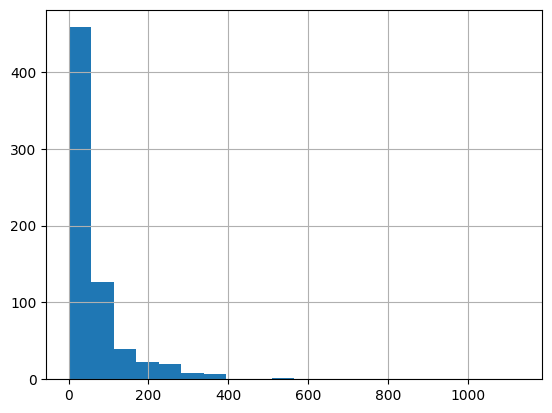

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 692
Total card age: 47342.35


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
171,JavaScript Concepts,Service Workers: Scripts that run in the backg...,00ddfe24a50a0070e1e9326eaac0e608,1129.283809,89.057578,1129.283809,4720.051612,0.957716
111,Terraform,Variable Interpolation:\nThe process of embedd...,fcac2b6b90bd08ddb9a3ef905a9e0f4b,1004.912157,91.984512,1004.912157,2299.612812,0.298427
0,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,937.206512,144.064975,937.206512,1728.779703,0.374424
112,Logging in Python,Q: How does RotatingFileHandler from the loggi...,60b9ac35727507199ed3d3b996ccab83,884.528789,163.471445,884.528789,4086.786129,0.667404
116,Logging in Python,Q: How can external log rotation tools like lo...,57b27fed5d075e5af65bbc29bdfdbaa4,643.318172,163.471445,884.528789,4086.786129,0.667404
71,Debugging in VS Code,Remote Debugging\nThe process of debugging cod...,ca5fab798a5c6204f74e192dcd55659b,611.546536,96.327166,611.546536,1830.216151,0.091498
275,Logging in Python,Q: What is the purpose of the disable_existing...,f803c674a61c80a7291f3ef06ceea119,537.986947,163.471445,884.528789,4086.786129,0.667404
110,Logging in Python,Q: What is one of the main disadvantages of us...,3753dbeb5ebfb4e424ec2fccd2df3557,532.854466,163.471445,884.528789,4086.786129,0.667404
445,Azure Developer Associate,Which Azure Monitor API lets you ingest custom...,ba1c9c8d01c752949032f768bd54b51c,476.329330,51.138571,476.329330,4500.194245,0.994870
200,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,429.119340,45.204104,429.119340,4023.165281,0.529110


# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [ ]:
# n = 4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
690,Vocab,Trimalleolar Fracture\nPronunciation: try-mal-...,4dcad89aa29d13661e3c94b11bc85736,0.086498,45.204104,429.119340,4023.165281,0.529110
475,Asynchronous Python,Cooperative Multitasking\nThe async model in P...,71ac5b970658e9c888a90c4478508455,0.090992,32.389474,157.869559,1489.915819,0.018288
551,JavaScript Concepts,Front: What are the benefits of using callback...,a2370fbf05a475780cf7c93745e623ab,0.113556,89.057578,1129.283809,4720.051612,0.957716
637,Azure Developer Associate,"In a multitenant Entra ID app, how many applic...",9810ab85f6e08995290955ede17f4e88,0.125531,51.138571,476.329330,4500.194245,0.994870
680,Azure Developer Associate,How do you temporarily prevent modifications o...,21117713fff05e435e78a6d087294d21,0.201057,51.138571,476.329330,4500.194245,0.994870
688,Vocab,Debride a Wound\nPronunciation: dih-BREED uh w...,80480f0451393019c45f9347790b2cd1,0.216739,45.204104,429.119340,4023.165281,0.529110
419,Python,Q:\nWhich Python module provides an object-ori...,e0f21808be1ac9152eaecf47c5a28d93,0.217541,88.325151,348.148457,4151.282102,0.220566
686,Vocab,Truckle\nPronunciation: TRUHK-uhl\nDefinition:...,5fdce68ef8fe3099d885821dfb12467d,0.220167,45.204104,429.119340,4023.165281,0.529110
574,Azure Developer Associate,What’s the maximum retention you can configure...,d5ee457fbd0609a88312665b94d8621e,0.221293,51.138571,476.329330,4500.194245,0.994870
689,Vocab,Codicil\nPronunciation: KOH-duh-sil\nDefinitio...,0310eee28c7c8e1d32a74a10ac19035c,0.245574,45.204104,429.119340,4023.165281,0.529110


In [18]:
existing_cards.head(10).sum()

head                   JavaScript ConceptsTerraformAudit Report Track...
body                   Service Workers: Scripts that run in the backg...
hash                   00ddfe24a50a0070e1e9326eaac0e608fcac2b6b90bd08...
age                                                          7187.086058
subject_mean_age                                             1171.662687
subject_highest_age                                          8126.512839
subject_age_sum                                             35449.164321
head_random_roll                                                5.915663
dtype: object

In [19]:
existing_cards['age'].mean()

68.41380119470335